# Naive Bayes and Decision Tree Algorithms Comparison

In this work, we provide two classification functions; Naive Bayes Classifier and Decision Tree Classifier. These methods are employed in data science studies to perform classification tasks on the given data. Even though both models are utilized for the same task, they differ from each other by the techniques that they are using and the mathematical background. By using these functions, the goal is to do a classification on a dataset and train a model that can suggest how the datapoints can be labeled with the most accurate way.

## Libraries

Numpy library is utilized to calculate the statistics. Pandas library is utilized to handle the datasets to map the features and targets in dataframe structure. Matplotlib and Seaborn libraries provide graphical representations presented in this work. The sklearn library is one of the main libraries employed in the data science area, here the helping functions classification_report and accuracy_score are used to gain information about model accuracy, train_test_split is utilized to split the dataset into training and test sets, LabelEncoder encodes target labels with value between 0 and n_classes-1. And counter function is the dictionary subclass used for counting the objects that are hashable.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
sns.set(style="whitegrid")

## Naive Bayes Classifier

Here in this function, the algorithm for the Naive Bayes Classifier is presented.
- prior function calculates prior probabilities P(y)
- stats function calculates mean ($\mu$) and varience ($\sigma$).
- density function calculates the probability from the Gaussian Distribution. $f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x - \mu}{\sigma})^2}$
- posterior function calculates the posterior probability for each class and returns the class with the highest posterior probabilty.
- fit function trains the model on the given dataset.
- predict function returns the predictions for the given data.

In [2]:
#Naive Bayes Classifier Class
class NaiveBayes:
    
    def prior(self, X, y):
        # calculate prior probability P(y)
        self.prior = (X.groupby(y).apply(lambda x: len(x)) / self.rows).to_numpy()
        return self.prior
    
    def stats(self, X, y):
        #calculate mean, variance for each column and convert to numpy array
        self.mu = X.groupby(y).apply(np.mean).to_numpy()
        self.sigma = X.groupby(y).apply(np.var).to_numpy()              
        return self.mu, self.sigma
    
    def density(self, class_idx, x):     
        #calculate probability from gaussian density function (normally distributed)
        mu = self.mu[class_idx]
        sigma = self.sigma[class_idx]
        n = np.exp((-1/2)*((x-mu)**2) / (2 * sigma))
        d = np.sqrt(2 * np.pi * sigma)
        p = n / d
        return p
    
    def posterior(self, x):
        posteriors = []
        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]     

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.count = len(self.classes)
        self.feature_nums = X.shape[1]
        self.rows = X.shape[0]
        
        self.stats(X, y)
        self.prior(X, y)
        
    def predict(self, X):
        preds = [self.posterior(f) for f in X.to_numpy()]
        return preds

## Decision Tree Classifier

There are two classes used in this Decision Tree classifier function. First class is to create the Node instances. Here in this function the node is checked for it's features, threshold, value, left and right values and provides information about if the tree keeps growing or not (is it a node or a leaf).

Decision Tree class handles the functions that are employed in the decision tree. There are three parameters; min_sample_split, max_depth and n_feats. These parameters are to fine tune the algorithm. fit and predict functions work the same way as Naive Bayes' fit and predict functions. grow function is a helping function that runs recursively until it reaches to leaves and this function constructs the tree (or rather grow the tree from its roots). Gini index is the function picked for this Decision tree and \_best_criteria function does the calculations for the best split possible. Split function does the splitting and traverse functions returns the information about the tree.

In [3]:
# Defining node for the tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.value = value
        self.left = left
        self.right = right    
    #to check for leaf node
    def is_leaf_node(self):
        return self.value is not None

In [4]:
class DecisionTree:
    def __init__(self, min_samples_split=5, max_depth=3, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self.grow(X, y)

    def predict(self, X):
        return np.array([self.traverse(x, self.root) for x in np.asarray(X)])

    def grow(self, X, y, depth=0):
        n_s, n_f = X.shape
        n_l = len(np.unique(y))
        if (depth >= self.max_depth or n_l == 1 or n_s < self.min_samples_split):
            _leaf = self.most_common_label(y)
            return Node(value = _leaf)
        f_i = np.random.choice(n_f, self.n_feats, replace=False)
        best_f, best_t = self._best_criteria(X, y, f_i)
        l_i, r_i = self.split(X[:, best_f], best_t)
        l = self.grow(X[l_i, :], y[l_i], depth+1)
        r = self.grow(X[r_i, :], y[r_i], depth+1)
        return Node(best_f, best_t, l, r)

    def _best_criteria(self, X, y, f_i):
        best_g = -1
        split_i, split_t = None, None
        for _f in f_i:
            X_column = X[:, _f]
            thresholds = np.unique(X_column)
            for t in thresholds:
                g = self.gini_index(y, X_column, t)
                if g > best_g:
                    best_g, split_i, split_t = g, _f, t
        return split_i, split_t

    def gini_index(self, y, X_column, split_t):
        parent_sumofsq = (1-np.sum([i * i for i in (np.bincount(y) / len(y)) if i > 0]))
        l_i, r_i = self.split(X_column, split_t)
        if len(l_i) == 0 or len(r_i) == 0:
            return 0
        n_l, n_r = len(l_i), len(r_i)
        e_l = (1-np.sum([i * i for i in (np.bincount(y[l_i]) / len(y[l_i])) if i > 0]))
        e_r = (1-np.sum([i * i for i in (np.bincount(y[r_i]) / len(y[r_i])) if i > 0]))
        child_sumofsq = (n_l / len(y)) * e_l + (n_r / len(y)) * e_r
        ig = parent_sumofsq - child_sumofsq 
        return ig

    def split(self, X_column, split_t):
        l_i, r_i = np.argwhere(X_column <= split_t).flatten(), np.argwhere(X_column > split_t).flatten()
        return l_i, r_i

    def traverse(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self.traverse(x, node.left)
        return self.traverse(x, node.right)

    def most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)
        if(len(most_common) > 0):
            most_common = most_common[0][0]
        else:
            most_common = 0.0
        return most_common

Accuracy on Different Train - Test Split Sizes:
A helping function that utilizes train_test_split from sklearn to automatically split the dataset. After then; fit, predict, store accuracy.
parameters:
- s = start of the steps
- e = end of the steps
- a = stride
- X and y = Features and targets.
  
Accuracy of Decision Tree with different maximum depth:
A hepling function that allows cross-validation on Decision Trees by varying maximum depth of the tree.

In [5]:
def split_accuracies(s, e, a, X, y):
    nb_scores, dt_scores = [], []
    for i in range(s, e, a):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (100-i)/100, random_state = 0)
        nb = NaiveBayes()
        dt = DecisionTree()
        nb.fit(X_train, y_train)
        dt.fit(X_train, y_train)
        nb_p = nb.predict(X_test)
        dt_p = dt.predict(X_test)
        nb_a = accuracy_score(y_test, nb_p)
        dt_a = accuracy_score(y_test, dt_p)
        nb_scores.append(nb_a)
        dt_scores.append(dt_a)
    return nb_scores, dt_scores

def depth_accuracies(X, y):
    depth_scores = []
    for i in range(1,11):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        dt = DecisionTree(max_depth=i, min_samples_split=5)
        dt.fit(X_train, y_train)
        dt_p = dt.predict(X_test)
        a = accuracy_score(y_test, dt_p)
        depth_scores.append(a)
    return depth_scores

## Experiment

First thing to do is to load the dataset. Then show the head of the data to observe the structure of the dataset. Head function outputs valuable information about dataset such as the features, the targets, the types of values stored etc.

In [6]:
df = pd.read_csv('data/iris.csv')
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
print(df.shape)
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X_train, X_test, y_train, y_test = X[:100], X[100:], y[:100], y[100:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(150, 5)
(100, 4) (100,)
(50, 4) (50,)


In [7]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

dt = DecisionTree()
dt.fit(X_train, y_train)

nb_p = nb.predict(X_test)
dt_p = dt.predict(X_test)

In [8]:
print("Naive Bayes Classifier report: \n\n", classification_report(y_test, nb_p))
print("Decision Tree Classifier report: \n\n", classification_report(y_test, dt_p))

Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.85      0.94      0.89        18
           2       0.91      0.77      0.83        13

   micro avg       0.92      0.92      0.92        50
   macro avg       0.92      0.90      0.91        50
weighted avg       0.92      0.92      0.92        50

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.79      0.83      0.81        18
           2       0.75      0.69      0.72        13

   micro avg       0.86      0.86      0.86        50
   macro avg       0.85      0.84      0.84        50
weighted avg       0.86      0.86      0.86        50



In [9]:
nb_scores, dt_scores = splitaccuracies(50, 100, 5, X, y)

In [10]:
print(nb_scores)
print(dt_scores)

[0.96, 0.9558823529411765, 0.9333333333333333, 0.9245283018867925, 0.9333333333333333, 0.9473684210526315, 0.9333333333333333, 0.9565217391304348, 0.9333333333333333, 0.875]
[0.8933333333333333, 0.8823529411764706, 0.8833333333333333, 0.9433962264150944, 0.9555555555555556, 0.9473684210526315, 0.9, 0.9565217391304348, 0.9333333333333333, 0.75]


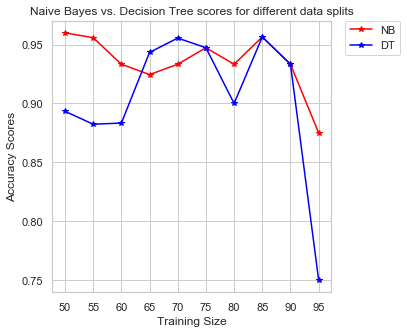

In [11]:
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(50, 100,5)], nb_scores, marker='*', color = 'red', label='NB')
plt.plot([i for i in range(50, 100,5)], dt_scores, marker='*', color = 'blue', label='DT')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.xticks(np.arange(50,100,5))
plt.ylabel('Accuracy Scores')
plt.title('Naive Bayes vs. Decision Tree scores for different data splits')
plt.show()

In [12]:
depth_scores = depthaccuracies(X, y)

In [13]:
print(depth_scores)

[0.6, 0.9111111111111111, 0.9333333333333333, 0.9555555555555556, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333]


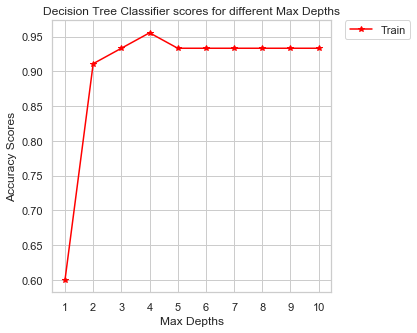

In [14]:
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(1,11)], depth_scores, marker='*', color = 'red', label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')
plt.show()

In [15]:
df = pd.read_csv("data/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


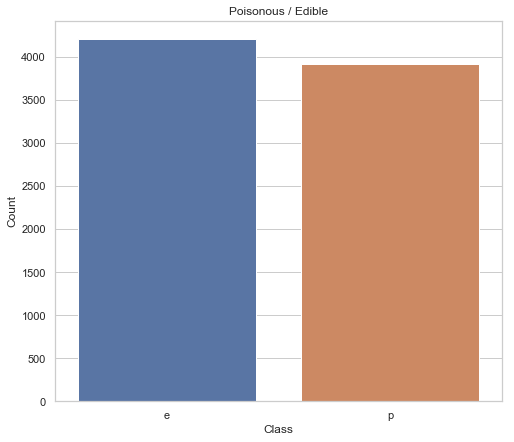

In [16]:
count = df['class'].value_counts()
plt.figure(figsize=(8,7))
sns.barplot(count.index, count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.title('Poisonous / Edible')
plt.show()

In [17]:
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
df = df.drop(["veil-type"],axis=1)
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [18]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

dt = DecisionTree()
dt.fit(X_train, y_train)

nb_p = nb.predict(X_test)
dt_p = dt.predict(X_test)

In [19]:
print("Naive Bayes Classifier report: \n\n", classification_report(y_test, nb_p))
print("Decision Tree Classifier report: \n\n", classification_report(y_test, dt_p))

Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.50      0.65       433
           1       0.63      0.96      0.76       380

   micro avg       0.72      0.72      0.72       813
   macro avg       0.78      0.73      0.71       813
weighted avg       0.79      0.72      0.70       813

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.98      0.94      0.96       433
           1       0.93      0.98      0.96       380

   micro avg       0.96      0.96      0.96       813
   macro avg       0.96      0.96      0.96       813
weighted avg       0.96      0.96      0.96       813



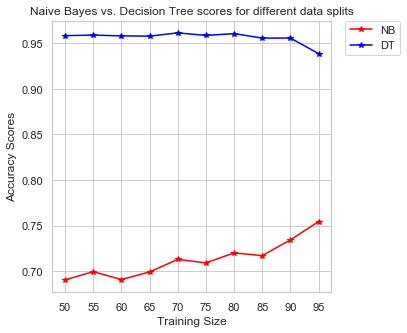

In [20]:
nb_scores, dt_scores = [], []
nb_scores, dt_scores = splitaccuracies(50, 100, 5, X, y)
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(50, 100,5)], nb_scores, marker='*', color = 'red', label='NB')
plt.plot([i for i in range(50, 100,5)], dt_scores, marker='*', color = 'blue', label='DT')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.xticks(np.arange(50,100,5))
plt.ylabel('Accuracy Scores')
plt.title('Naive Bayes vs. Decision Tree scores for different data splits')
plt.show()

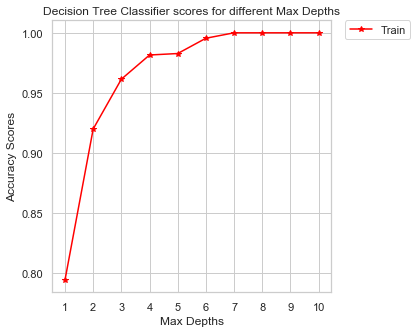

In [21]:
depth_scores = depthaccuracies(X, y)
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(1,11)], depth_scores, marker='*', color = 'red', label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')
plt.show()

In [22]:
df = pd.read_csv('data/data.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.10,0.90,7,286,4,0,1,0,sales,low
1,0.89,0.93,4,249,3,0,0,0,sales,low
2,0.38,0.50,2,132,3,0,1,0,accounting,low
3,0.95,0.71,4,151,4,0,0,0,sales,medium
4,0.84,0.84,5,163,3,0,0,0,technical,low


In [23]:
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
X = df.drop(['left'], axis=1)
y = df['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [24]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

dt = DecisionTree()
dt.fit(X_train, y_train)

nb_p = nb.predict(X_test)
dt_p = dt.predict(X_test)

In [25]:
print("Naive Bayes Classifier report: \n\n", classification_report(y_test, nb_p))
print("Decision Tree Classifier report: \n\n", classification_report(y_test, dt_p))

Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.88      0.89      0.88       833
           1       0.67      0.65      0.66       291

   micro avg       0.83      0.83      0.83      1124
   macro avg       0.78      0.77      0.77      1124
weighted avg       0.83      0.83      0.83      1124

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.97      0.96      0.96       833
           1       0.89      0.92      0.90       291

   micro avg       0.95      0.95      0.95      1124
   macro avg       0.93      0.94      0.93      1124
weighted avg       0.95      0.95      0.95      1124



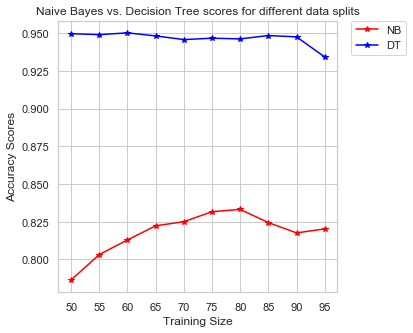

In [26]:
nb_scores, dt_scores = [], []
nb_scores, dt_scores = splitaccuracies(50, 100, 5, X, y)
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(50, 100,5)], nb_scores, marker='*', color = 'red', label='NB')
plt.plot([i for i in range(50, 100,5)], dt_scores, marker='*', color = 'blue', label='DT')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.xticks(np.arange(50,100,5))
plt.ylabel('Accuracy Scores')
plt.title('Naive Bayes vs. Decision Tree scores for different data splits')
plt.show()

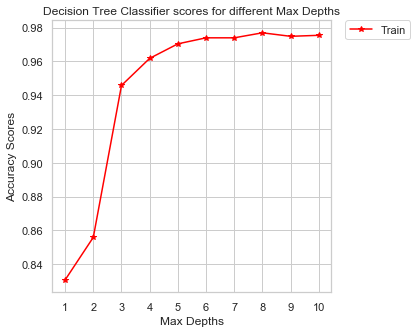

In [27]:
depth_scores = depthaccuracies(X, y)
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(1,11)], depth_scores, marker='*', color = 'red', label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')
plt.show()

In [28]:
# https://www.kaggle.com/datasets/vivekgediya/banknote-authenticationcsv
df = pd.read_csv('data/banknote.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Heatmap of the correlations in-between different features.

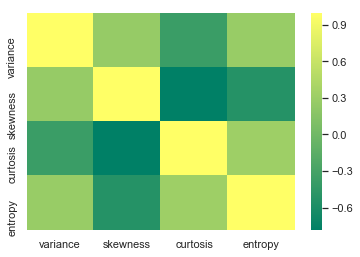

In [29]:
correlations = df.drop(columns=['class']).corr()
sns.heatmap(correlations,cmap='summer')

Target feature in the Banknotes dataset is defined as class. It is a binary classification that value 0 responds to "fake" classification and value 1 responds to "real". By plotting the number of the classes, some insight can be gained about the dataset, here the number of output classes does not differ from each to cause imbalance.

0    762
1    610
Name: class, dtype: int64


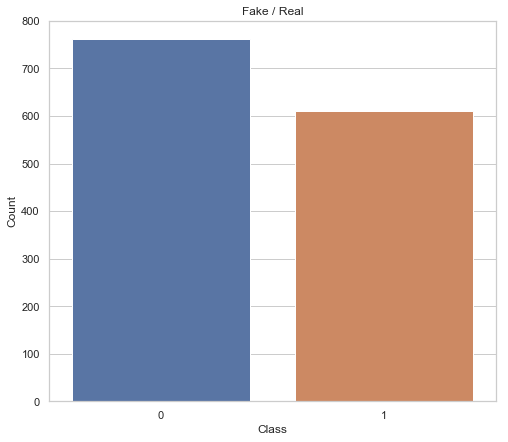

In [30]:
print(df['class'].value_counts())
count = df['class'].value_counts()
plt.figure(figsize=(8,7))
sns.barplot(count.index, count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.title('Fake / Real')
plt.show()

All the labels are encoded. The data is splitted into training and test sets with percentages of 70 and 30 respectively.

In [31]:
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

Here the two classification functions are fit to the training data, then the test data is employed to evaluate the models.

In [32]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

dt = DecisionTree()
dt.fit(X_train, y_train)

nb_p = nb.predict(X_test)
dt_p = dt.predict(X_test)

classification_report function provided by sklearn libraries can shed some light upon the accuracy of the model. Here, results for 3 different metrics can be seen on the output.

In [33]:
print("Naive Bayes Classifier report: \n\n", classification_report(y_test, nb_p))
print("Decision Tree Classifier report: \n\n", classification_report(y_test, dt_p))

Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.86      0.92      0.89       229
           1       0.89      0.81      0.85       183

   micro avg       0.87      0.87      0.87       412
   macro avg       0.87      0.87      0.87       412
weighted avg       0.87      0.87      0.87       412

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.91      0.96      0.93       229
           1       0.94      0.89      0.91       183

   micro avg       0.92      0.92      0.92       412
   macro avg       0.93      0.92      0.92       412
weighted avg       0.93      0.92      0.92       412



This section of the code is about validation of the models. First, the split_accuracies function is used to cross-validate both models on different train - test split sizes. The results for both models are presented with a graph.

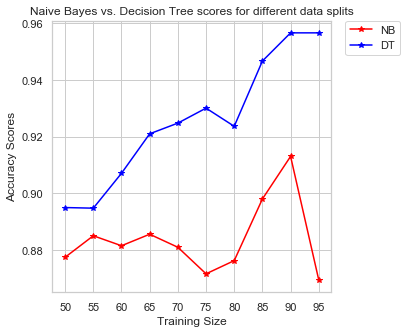

In [34]:
nb_scores, dt_scores = [], []
nb_scores, dt_scores = splitaccuracies(50, 100, 5, X, y)
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(50, 100,5)], nb_scores, marker='*', color = 'red', label='NB')
plt.plot([i for i in range(50, 100,5)], dt_scores, marker='*', color = 'blue', label='DT')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.xticks(np.arange(50,100,5))
plt.ylabel('Accuracy Scores')
plt.title('Naive Bayes vs. Decision Tree scores for different data splits')
plt.show()

Another cross-validation application for Decision Tree model only. Here the maximum depth of the tree is varied to see how it effects the accuracy.

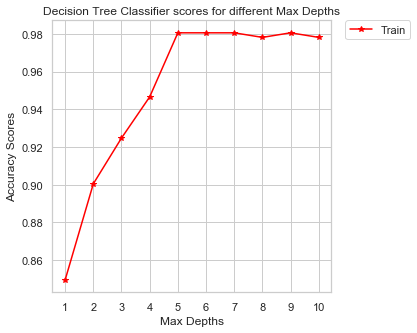

In [35]:
depth_scores = depthaccuracies(X, y)
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(1,11)], depth_scores, marker='*', color = 'red', label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')
plt.show()